# Spot-Crossing Transit & Absorption Time-Series

In this notebook, we simulate a Sun-like star hosting a Jupiter-sized planet, representing the stellar local spectra with a PHOENIX model. We compute a time series of spectra during the planetary transit within the wavelength range 5882–5902 Å, and from these obtain the corresponding absorption time series in the stellar rest frame. We then illustrate the evolution of the absorption spectra as the planet moves across the stellar disk. In addition, we incorporate a central starspot with a radius equal to 10% of the stellar radius and a temperature contrast of −600 K, modeled using the appropriate PHOENIX spectrum for the spot temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm
from SOAP.utils import transgrad, compute_planet_doppler_shift, transit_durations
from SOAP.visualizer import plot_absorption_map
import SOAP
from SOAP import PHOENIX
from SOAP.fast_starspot import doppler_shift
from astropy.constants import M_earth, M_sun
from IPython.display import HTML

In [2]:
# Star-like star, rigid rotation
radius=1                # Stellar radius [solar radii]
mass=1                  # Stellar mass [solar masses]
prot=24.47              # Stellar rotation period [days]
incl=90                 # Stellar inclination [degrees] -> 90 is equator-on, 0 is pole-on
logg= 4.4               # Stellar surface gravity [cgs]
feh= 0.00               # Stellar metallicity [dex]
Teff=5777               # Stellar effective temperature [K]
ldcn=[[0.5,0.16]]       # Linear and quadratic limb-darkening coefficients
start_psi=0.0           # Starting phase of the star

# Mock jupiter-like planet close to the star
Pp=3                    # Orbital period [days]
e=0.0                   # Orbital eccentricity
w=90.0                  # Argument of periastron [degrees]
ip=90                   # Orbital inclination [degrees]
lbda=0                  # Sky-projected spin-orbit misalignement [degrees]
a=9                     # Semi-major axis [stellar radii]
Rp=0.15                 # Planetary radius [stellar radii]
Mp=317.8                # Planetary mass [Earth masses]

# Observational parameters
λ =[5882, 5902]         # Wavelength range [Angstrom]
Res=140000              # Instrumental resolution

Where we use will import Phoenix spectra that match the stellar properties. These will be used to compute the RVs in the simulation

In [3]:
spQ = PHOENIX(wave_range=λ, normalize=True, teff=Teff, logg=logg, Z=feh)
spQ_active = PHOENIX(wave_range=λ, normalize=True, teff=Teff, logg=logg, Z=feh, contrast=-600, spot=True)

tplt={"wave":spQ.wave, "flux":spQ.flux} # Template spectrum matching the input local spectra to cumpute the RVs

# Start the simulation

In [4]:
sim = SOAP.Simulation(pixel=spQ, pixel_spot=spQ_active, wlll=(λ[1]+λ[0])/2, inst_reso=Res, grid=600, active_regions=[], ring=None)

In [5]:
sim.active_regions=[SOAP.ActiveRegion(check = True,
                             lon = 0,
                             lat = 0,
                             size = 0.1 ,
                             temp_diff = 600, # in K, this is the default value
                             active_region_type = 0
                            )]

In [6]:
# Set the properties of the star and planet
sim.star.set(prot=prot,incl=incl,u1=ldcn[0][0],u2= ldcn[0][1], start_psi=start_psi,radius=radius,mass=mass,teff=Teff)
sim.planet.set(P=Pp,t0=start_psi,e=e,w=w,ip=ip,lbda=lbda,a=a,Rp=Rp,Mp=Mp)

In [7]:
# Provide the range of stellar phases to simulate
psi = np.linspace(-0.1,0.1,50) / sim.star.prot

In [8]:
# Calculate the transit signal
out=sim.calculate_signal(psi, renormalize_rv=True, template=tplt)

In [9]:
# Convert from transmission to absorption [%]
absorption_spec=(1-sim.pixel_trans)*100

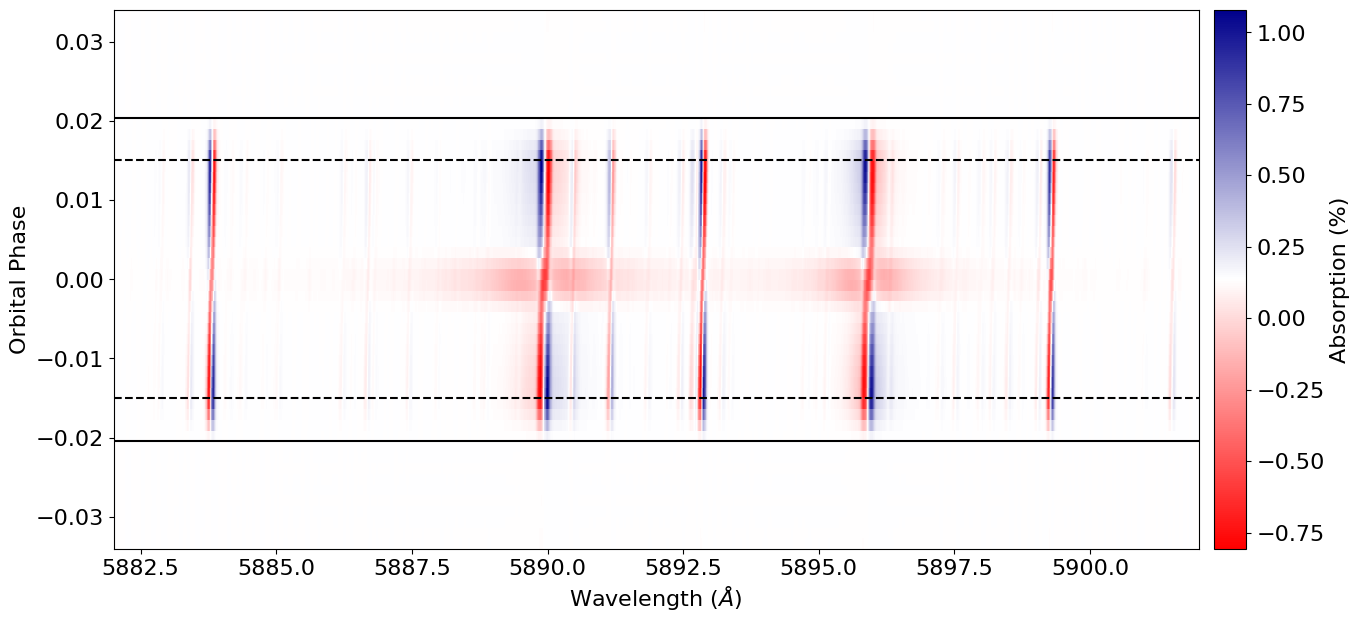

In [10]:
# Plot the absorption map in the stellar rest frame
fig, ax = plot_absorption_map(sim,psi, absorption_spec,λ)
plt.show()


In [11]:
# Doppler shift of the map to the planetary rest frame
absorpt_prest=compute_planet_doppler_shift(sim,psi,absorption_spec)

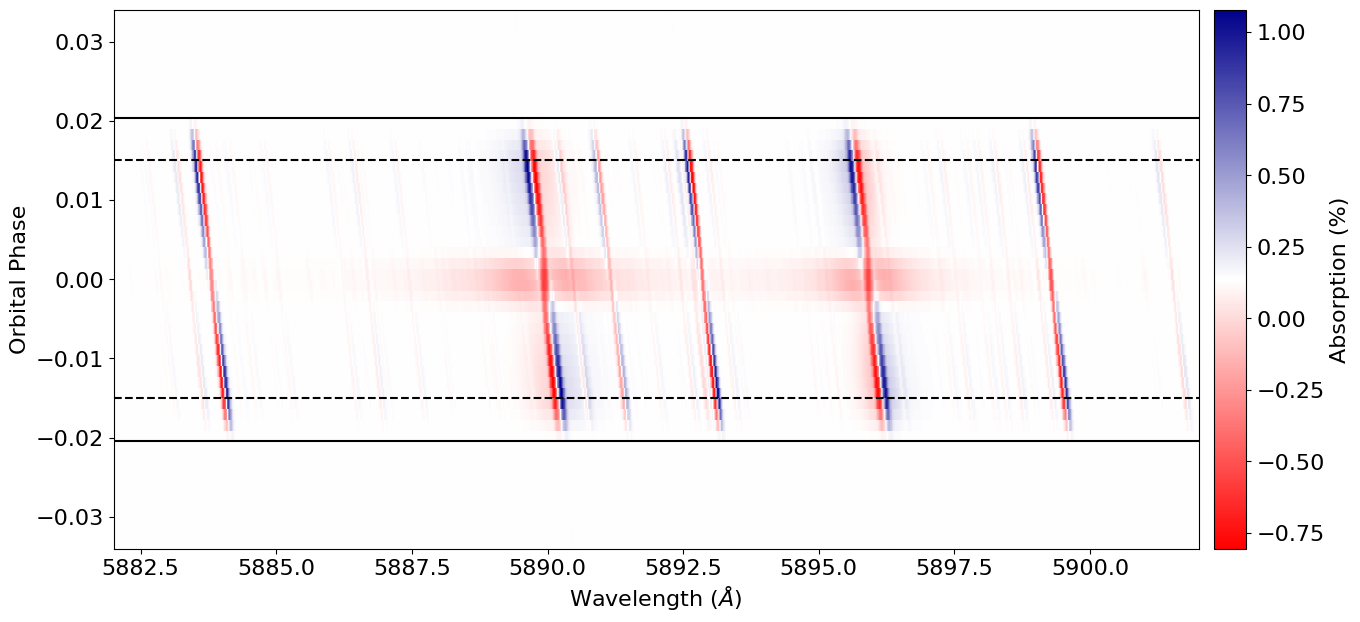

In [12]:
# Plot the absorption map in the planet rest frame
fig, ax = plot_absorption_map(sim,psi,absorpt_prest,λ)
plt.show()

In [13]:
# Create an animation of the transit with the absorption map
ani = sim.visualize_animation(
    output=out,
    plot_type="tr",
    lim=[5889.950-1.5, 5889.950+1.5],
    ref_wave=5889.950,
    plot_lims=[-1.1, 1.1]
)
HTML(ani.to_jshtml())